# Cargamos Datos

In [27]:
import fastai
import torch
from fastai.vision import *
from shutil import copyfile
plt.rcParams.update({'font.size': 18})
from fastai.metrics import AUROC
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing


In [28]:
dic = {
      'ATYPICAL_LYMPHOCYTE':[],
      'VARIANT_LYMPHOCYTE':[],
      'BLAST':[]
     }

## Se crean los directorios de células de CanRuti

In [29]:
def print_dirs_recursively(root_dir):
    root_dir = os.path.abspath(root_dir)

    for item in os.listdir(root_dir):
        item_full_path = os.path.join(root_dir, item)
        if os.path.isdir(item_full_path):
            print_dirs_recursively(item_full_path)
        else: 
            if '/SLPC/' in item_full_path:
                dic['ATYPICAL_LYMPHOCYTE'].append(item_full_path)
            if '/REACTIUS/' in item_full_path:
                dic['VARIANT_LYMPHOCYTE'].append(item_full_path)
            if '/LA/' in item_full_path:
                dic['BLAST'].append(item_full_path)

print_dirs_recursively('/shared/can_ruti')

In [30]:
#for item in dic.values():
#    for path in item:
#
#        if '/SLPC/' in path:
#            filename = os.path.basename(path)
#            copyfile(path, os.path.join("/shared/Classification_CanRuti/ATYPICAL_LYMPHOCYTE", filename))
#      
#        if '/REACTIUS/' in path:
#            filename = os.path.basename(path)
#            copyfile(path, os.path.join("/shared/Classification_CanRuti/VARIANT_LYMPHOCYTE", filename))
#            
#        if '/LA/' in path:
#            filename = os.path.basename(path)
#            copyfile(path, os.path.join("/shared/Classification_CanRuti/BLAST", filename))            
#                    
#
#

#### Descripción del Conjunto de datos de validación de Can Ruti

In [31]:
folder_1 = os.listdir("/shared/Datasets_Classification/Classification_CanRuti/ATYPICAL_LYMPHOCYTE")
folder_2 = os.listdir("/shared/Datasets_Classification/Classification_CanRuti/VARIANT_LYMPHOCYTE")
folder_3 = os.listdir("/shared/Datasets_Classification/Classification_CanRuti/BLAST")
dic_Classif = {
      'ATYPICAL_LYMPHOCYTE':len(folder_1),
      'VARIANT_LYMPHOCYTE':len(folder_2),
      'BLAST':len(folder_3)
     }

pd.DataFrame(dic_Classif, index=['N'])

,ATYPICAL_LYMPHOCYTE,VARIANT_LYMPHOCYTE,BLAST
N,47,57,80


In [32]:
folder_classes = "/shared/Datasets_Classification/Classification_CanRuti"
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)





#### Creación de DataBunch

In [33]:
data = (ImageList.from_folder(folder_classes) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.5,seed=4)           #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch()
        .normalize(imagenet_stats))   

In [34]:
data.batch_size = 20

#### Descripción de conjuntos `train` y `valid` (validation set será el `test`)

In [35]:
pd.DataFrame.from_dict({'Number of classes':[data.c],
'train_size':[len(data.train_ds)],
'valid_size':[len(data.valid_ds)]},
orient = 'index', columns=['N'])

,N
Number of classes,3
train_size,92
valid_size,92


#### Descripción del reparto de clases en cada set

`Train set`

In [36]:
train_ds = data.train_ds.to_df()
train_df = pd.DataFrame(train_ds['y'].value_counts()).rename(columns={'y':'Número de imágenes en el train set'})
train_df

,Número de imágenes en el train set
BLAST,43
VARIANT_LYMPHOCYTE,27
ATYPICAL_LYMPHOCYTE,22


`Validation set`

In [37]:
valid_ds = data.valid_ds.to_df()
test_df = pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'Número de imágenes en el test set'})
test_df

,Número de imágenes en el test set
BLAST,37
VARIANT_LYMPHOCYTE,30
ATYPICAL_LYMPHOCYTE,25


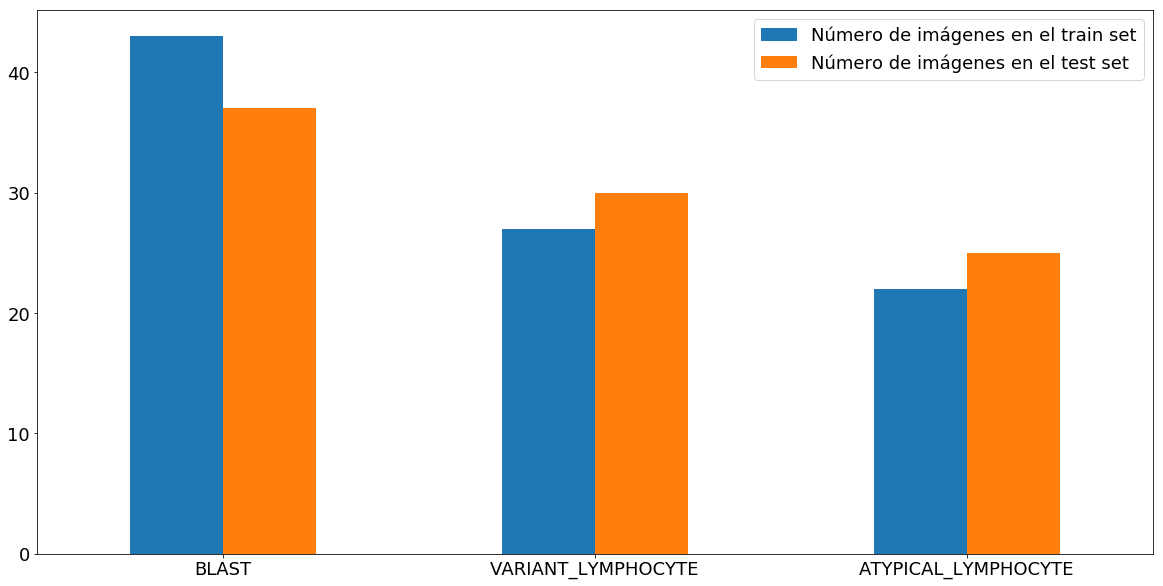

In [38]:
train_df['Número de imágenes en el test set'] = test_df['Número de imágenes en el test set']
train_df.plot.bar(figsize=(20,10), rot=0);

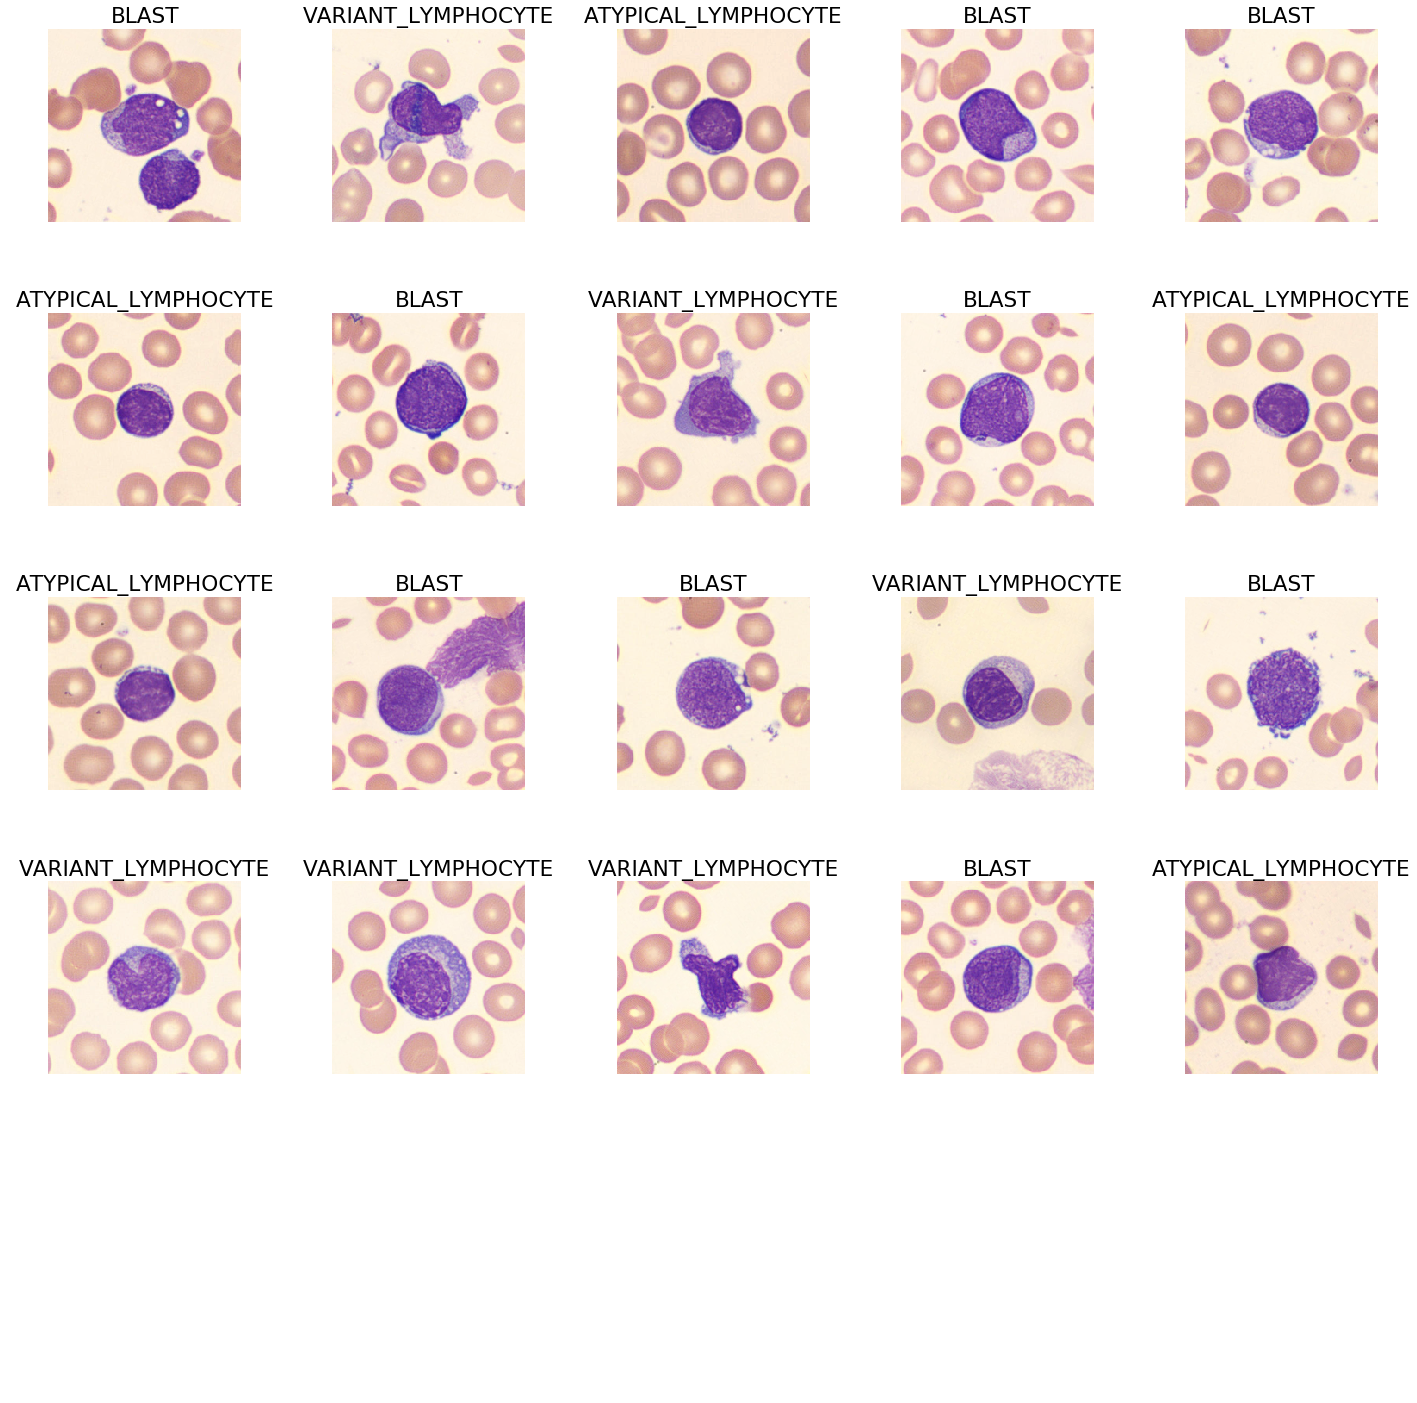

In [39]:
data.show_batch()

# Test Canruti Resnet 18 Preentrenada en Clinic - Dataset Can Ruti Original

Se crea un learner con datos auxilares del clinic pero se sustituye con el Databunch de CanRuti anterior para validar en CanRuti. Nótese que se incorporan los pesos del clínic con el método `.load()`

In [40]:
folder_model = "/shared/Datasets_Classification/Classification_Clinic_Balanced"
learn = None
learn = load_learner(folder_model, 'export_stage-2-18-Clinic_Balanced_3_Classes')
learn.data = data


Estadísticas de la validación den CanRuti

In [41]:

results = learn.validate(data.valid_dl)
results
valid_CanRuti = dict(zip(['valid_loss', 'error_rate', 'accuracy'],
                         [results[0], results[1].item(),results[2].item()]))

pd.DataFrame(valid_CanRuti, index = ['metrics'])

,valid_loss,error_rate,accuracy
metrics,9.440229,0.684783,0.315217


In [43]:
plt.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score

def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

val_preds,val_targets = learn.get_preds() 

y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes)))


precision = precision_score(y_test, y_true, average='micro')
recall = recall_score(y_test, y_true, average='micro')

pd.DataFrame({#'multiclass_roc_auc_score': multiclass_roc_auc_score(y_test, y_true),
             'precision':precision,
             'recall':recall,
             }, index = ['metrics'])

,precision,recall
metrics,0.315217,0.315217


`Matriz de confusión` de la validación en Can Ruti

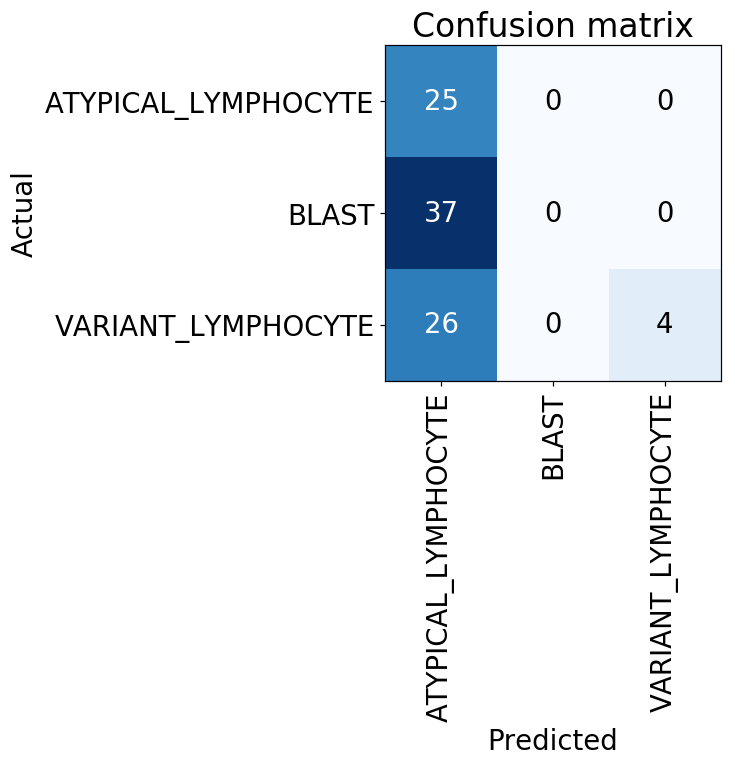

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)



`Matriz de confusión normalizada` de la validación en Can Ruti

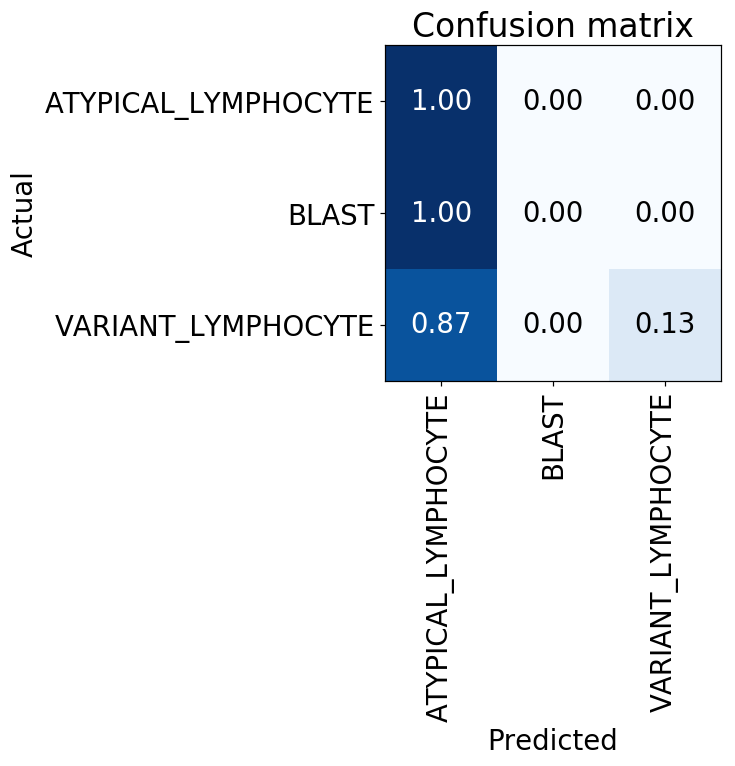

In [45]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

In [46]:
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

#### Fine Tuning en el conjunto de CanRuti

In [47]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=(3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.160189,3.185868,0.510870,0.489130,00:00
1,0.875122,0.752520,0.163043,0.836957,00:00


In [48]:
learn.fit_one_cycle(2, max_lr=(3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.270453,0.468473,0.141304,0.858696,00:00
1,0.285091,0.378122,0.130435,0.869565,00:00


In [49]:
learn.fit_one_cycle(2, max_lr=(3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.142036,0.318946,0.108696,0.891304,00:00
1,0.235687,0.233437,0.086957,0.913043,00:00


In [50]:
learn.fit_one_cycle(2, max_lr=(3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.173343,0.117178,0.021739,0.978261,00:00
1,0.118542,0.118220,0.032609,0.967391,00:00


In [51]:
learn.fit_one_cycle(2, max_lr=(3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.152387,0.156731,0.043478,0.956522,00:00
1,0.112636,0.164105,0.043478,0.956522,00:00


In [52]:
learn.fit_one_cycle(2, max_lr=(3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.023390,0.168220,0.043478,0.956522,00:00
1,0.025474,0.159881,0.043478,0.956522,00:00


In [53]:
plt.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score

def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

val_preds,val_targets = learn.get_preds() 

y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes)))


precision = precision_score(y_test, y_true, average='micro')
recall = recall_score(y_test, y_true, average='micro')

pd.DataFrame({'multiclass_roc_auc_score': multiclass_roc_auc_score(y_test, y_true),
             'precision':precision,
             'recall':recall,
             }, index = ['metrics'])

,multiclass_roc_auc_score,precision,recall
metrics,0.967391,0.956522,0.956522


In [54]:
interp = ClassificationInterpretation.from_learner(learn)

interp.most_confused(min_val=2)

[('VARIANT_LYMPHOCYTE', 'ATYPICAL_LYMPHOCYTE', 4)]

`Matriz de confusión` tras el fine tuning en Can Ruti

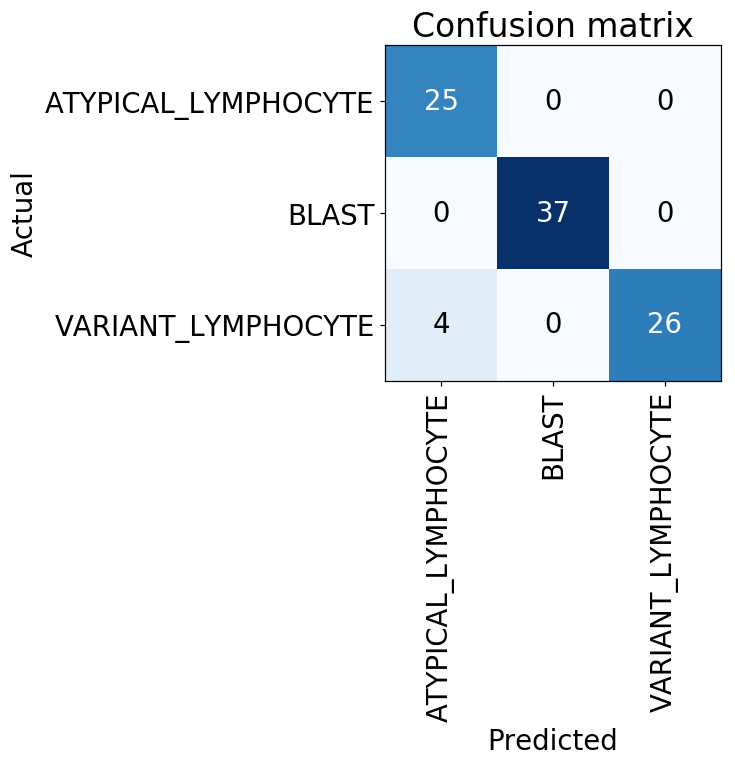

In [55]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)

`Matriz de confusión Normalizada` tras el fine tuning en Can Ruti

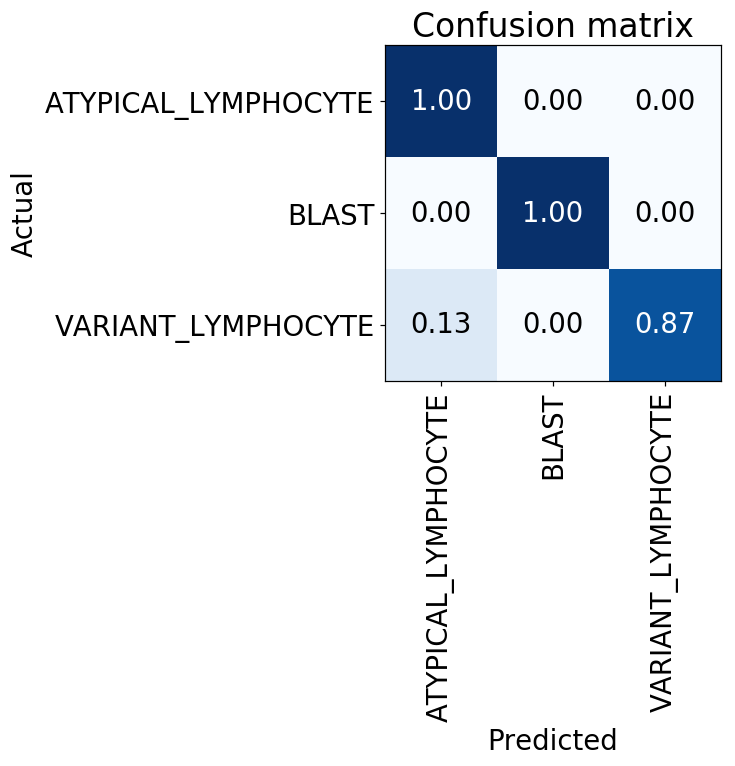

In [56]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

In [38]:
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
interp.plot_top_losses(9, largest=True, figsize=(35,35))

